In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())
# c:\workspace\autoencoder\02_autoencoder

c:\workspace\autoencoder\02_autoencoder


In [6]:
# 스크립트 실행 경로 변경
# c:\workspace\autoencoder\02_autoencoder 으로 변경
os.chdir('c:/workspace/autoencoder/02_autoencoder')

In [7]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())

c:\workspace\autoencoder\02_autoencoder


In [8]:
# 하위에 dataset 폴더가 존재하지 않으면 생성
os.makedirs('./dataset', exist_ok=True)

In [9]:
# zip file(.wav files) 압축 해제
import zipfile



In [10]:
# fantasy_zip = zipfile.ZipFile('./36cc.zip')
# fantasy_zip.extractall('./dataset/')
# fantasy_zip.close()

In [11]:
fantasy_zip = zipfile.ZipFile('./57cc.zip')
fantasy_zip.extractall('./dataset/')
fantasy_zip.close()

In [12]:
########################################################################

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, np.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################

In [13]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               n_mels=128,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # file = SOURCE
    # y, sr = librosa.load(file) # (default  sr=22050)
    # Return
      # y: np.ndarray [shape=(n,) or (…, n)] / audio time series. Multi-channel is supported.
      # sr: number > 0 [scalar / sampling rate of
    # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=(15, 15))
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [14]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge2(SOURCE, TARGET, FIG_SIZE):

    # 01 calculate the number of dimensions
    #dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # STFT -> spectrogram
    hop_length = 512  # in num. of samples
    n_fft = 2048  # window in num. of samples

    # perform stft
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)  # np.abs(stft) ** 2

    # apply logarithm to cast amplitude to Decibels
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=FIG_SIZE)
      plt.axis('off')
      librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [15]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [16]:
# https://wfdb.readthedocs.io/en/latest/wfdb.html?highlight=rdrecord#wfdb.rdrecord
# Read a WFDB record and return the signal and record descriptors as attributes in a Record or MultiRecord object.
rd_record = wfdb.rdrecord('pure_0.wav')

Reading Mono formatted .wav file...
Sample rate: 44100
Byte rate: 88200
Block align: 2
Bits per sample: 16


In [17]:
# rd_record = wfdb.rdrecord('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')

In [18]:
# https://ahnjg.tistory.com/84
# librosa.load와 scipy.io.wavfile.read의 차이점
# librosa로 데이터를 읽으면 데이터의 범위가 -1 ~ 1의 범위로 정규화된다
# librosa의 입력에서 sr=None으로 지정하지 않고 임의의 sample_rate를 설정하면 load 할 때 resampling을 수행합니다.


In [19]:
import scipy.io.wavfile
scipy_sr, scipy_y = scipy.io.wavfile.read('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')
# Sample rate: 51200, Byte rate: 102400

In [20]:
print(f"scipy_sr = {scipy_sr}")
# Sample rate를 원래의 Sample rate로 가져온다.

scipy_sr = 51200


In [21]:
print(f"scipy_y.shape = {scipy_y.shape}")
# print(f"number of channels = {scipy_y.shape[1]}")

scipy_y.shape = (819200,)


In [22]:
wavelength = scipy_y.shape[0] / scipy_sr
print(f"length = {wavelength}s")
# 26초 길이를 가지고 있다.

length = 16.0s


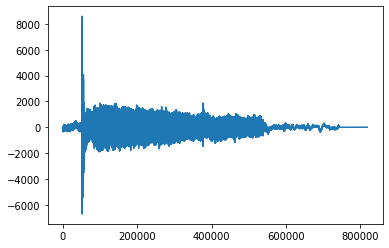

In [23]:
plt.plot(scipy_y)
# scipy로 가져오면 데이터 분포가 약 -1000 ~ 750 이다.

In [24]:
librosa_y, librosa_sr = librosa.load('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')

In [25]:
print('scipy_y.shape:', scipy_y.shape)
print('type(scipy_y[0]):', type(scipy_y[0]))
print('scipy_sr:', scipy_sr)
print('--------------------------------------')
print('librosa_y.shape:', librosa_y.shape)
print('type(librosa_y[0]):', type(librosa_y[0]))
print('librosa_sr:', librosa_sr)
# librosa는 Sample Rate를 지정하지 않으면 기본 sr=22050으로 지정된다.

scipy_y.shape: (819200,)
type(scipy_y[0]): <class 'numpy.int16'>
scipy_sr: 51200
--------------------------------------
librosa_y.shape: (352800,)
type(librosa_y[0]): <class 'numpy.float32'>
librosa_sr: 22050


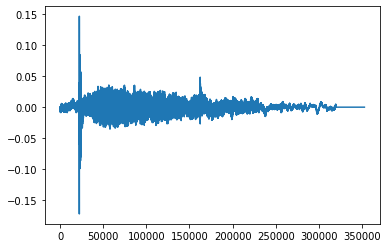

In [26]:
plt.plot(librosa_y)
# librosa는 데이터 범위가 -1~1로 정규화 된다.

C:\Users\astro\AppData\Local\Temp\ipykernel_16032\4076579627.py:6: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(librosa_y, librosa_sr)#, alpha=0.5)


Text(0.5, 1.0, 'librosa.display.waveshow(y=audio time series, sr=sampling rate')

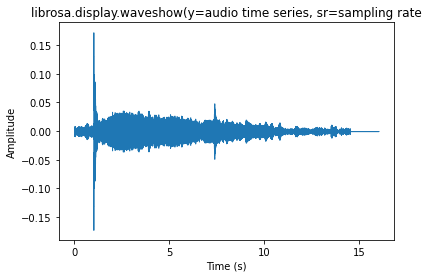

In [27]:
# https://www.dacon.io/competitions/official/235616/codeshare/1277
# https://librosa.org/doc/0.9.1/generated/librosa.display.waveshow.html#librosa.display.waveshow
# Visualize a waveform in the time domain
# y축은 진폭, x축은 시간을 나타낸다.
plt.figure()
librosa.display.waveshow(librosa_y, librosa_sr)#, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("librosa.display.waveshow(y=audio time series, sr=sampling rate")
# Amplitude: 진폭: 진동하고 있는 물체가 정지 또는 평형 위치에서 최대 변위까지 이동하는 거리. 진동하는 폭의 절반이다.

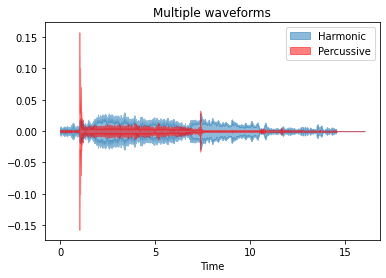

In [28]:
fig, ax = plt.subplots(nrows=1, sharex=True)
y_harm, y_perc = librosa.effects.hpss(librosa_y)
librosa.display.waveshow(y_harm, sr=librosa_sr, alpha=0.5, ax=ax, label='Harmonic')
librosa.display.waveshow(y_perc, sr=librosa_sr, color='r', alpha=0.5, ax=ax, label='Percussive')
ax.set(title='Multiple waveforms')
ax.legend()
# Harmonic: 배음: 진동체가 내는 여러 가지 소리 가운데, 원래 소리보다 큰 진동수를 가진 소리. 보통 원래 소리의 정수배(整數倍)가 되는 소리를 이른다.
# (바이올린 같은 악기의 현을 살짝 건드려 낼 수 있는) 고음
# Percussive: (특히 타악기를) 쳐서 소리를 내는
# https://jonhyuk0922.tistory.com/114
# * Harmonics : 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)
# * Percussives: 리듬과 감정을 나타내는 충격파

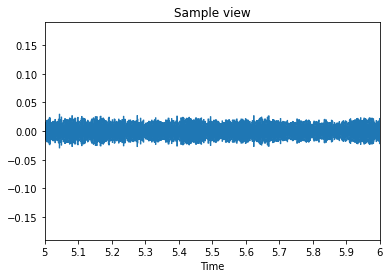

In [29]:
# https://www.dacon.io/competitions/official/235616/codeshare/1277
# https://librosa.org/doc/0.9.1/generated/librosa.display.waveshow.html#librosa.display.waveshow
fig, ax = plt.subplots(nrows=1, sharex=True)
ax.set(xlim=[5.00, 6.00], title='Sample view')#, ylim=[-0.2, 0.2])
librosa.display.waveshow(librosa_y, sr=librosa_sr, ax=ax, marker='.', label='Full signal')
ax.label_outer()
#Rax.legend()

In [30]:
import seaborn as sns

c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

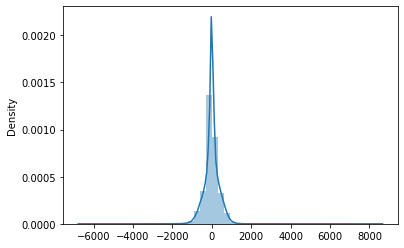

In [31]:
# scipy와 librosa로 가져온 데이터의 분포를 살펴보겠습니다.
# https://ahnjg.tistory.com/84
sns.distplot(scipy_y)

c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

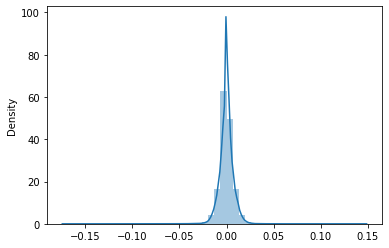

In [32]:
# librosa로 가져온 데이터는 -1 ~ 1 의 범위로 정규화 되어있다.
# liborsa 입력에서 sr=None 로 지정하지 않고 임의의 sample_rate를 설정하면 load할 때 resampling을 수행한다.
sns.distplot(librosa_y)

In [33]:
import matplotlib.pyplot as plt

22050


C:\Users\astro\AppData\Local\Temp\ipykernel_16032\3375670222.py:14: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y, sr, ax=ax)


Text(30.375, 0.5, 'Amplitude')

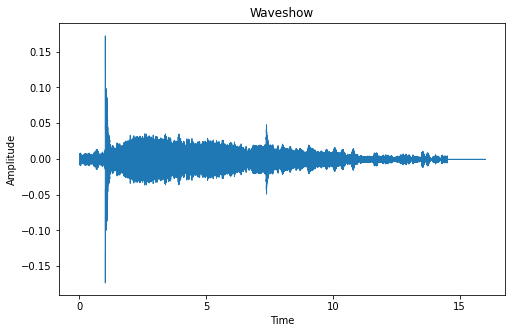

In [34]:
# amplitude: 진폭
# waveshow
# https://librosa.org/doc/latest/generated/librosa.display.waveshow.html
# Librosa 라이브러리의 load함수로 wav파일을 불러와 waveshow를 통해 소리데이터의 Time domain 파형을 시각화 합니다
# Sampling rate는 오디오에 맞게 설정할 수 있으며, 설정하지 않으면 기본값인 22050으로 불러오게 됩니다.
# 그림[1]는 waveshow함수를 통해 wav파일을 시각화 한 것이며, x축은 Time, y축은 진폭을 나타냅니다.
# https://hyongdoc.tistory.com/401?category=884319


y, sr = librosa.load('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')
print(sr)

fig, ax = plt.subplots(nrows=1, figsize=(8,5))
librosa.display.waveshow(y, sr, ax=ax)
ax.set(title='Waveshow')
ax.set_ylabel('Amplitude')

22050


C:\Users\astro\AppData\Local\Temp\ipykernel_16032\3579233413.py:5: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y, sr, ax=ax)


Text(36.75, 0.5, 'Amplitude')

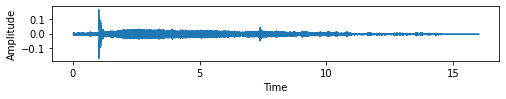

In [35]:
y, sr = librosa.load('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')
print(sr)

fig, ax = plt.subplots(nrows=1, figsize=(8,1))
librosa.display.waveshow(y, sr, ax=ax)
# ax.set(title='Waveshow')
ax.set_ylabel('Amplitude')

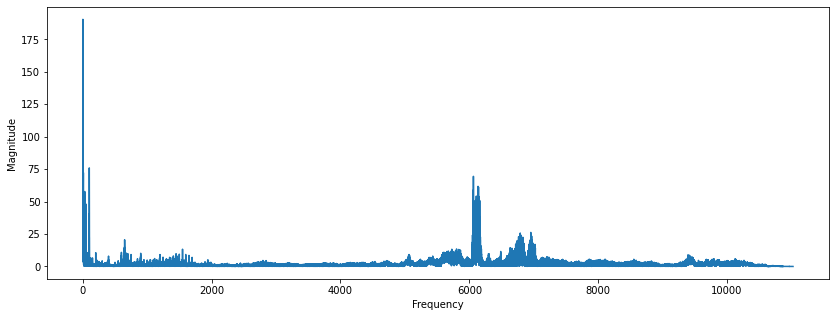

In [36]:
# https://lucaseo.github.io/posts/2021-01-22-hands-on-preprocess-audio-data/
# FFT (Fast Fourier Transform)
# waveform amplitude에 FFT를 적용
y, sr = librosa.load('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')

# y = audio time series. Multi-channel is supported. | np.ndarray [shape=(n,) or (…, n)]
# sr = sampling rate of y | number > 0 [scalar]

fft = np.fft.fft(y)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

fig = plt.figure(figsize = (14,5))
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# Magnitude vs Amplitude 차이점
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=suya309&logNo=221023654826

# magnitude: Magnitude는 어떤 주기적 진동의 절대치를 의미하며
# Amplitude: 전압파 형상에서 특정 위치의 높이값을 의미 한다

# Magnitude는 방향을 고려하지 않는 scalar 이며, frequency domain에서 주로 사용 한다.
# Amplitude는 방향을 고려하는 vector 이며, time domain에서 주로 사용 한다.

# magnitude: 규모[중요도]
# Amplitude: 진폭: 진동하고 있는 물체가 정지 또는 평형 위치에서 최대 변위까지 이동하는 거리. 진동하는 폭의 절반이다.

# FFT를 적용하여 시각화한 결과는 아래와 같습니다. 주로 2000Hz 이하로 많이 분포해 있는 것을 확인할 수 있네요.

In [37]:
# https://lucaseo.github.io/posts/2021-01-22-hands-on-preprocess-audio-data/
# STFT(Short-Time Fourier Transform)은 시간 정보가 유실되는 것을 방지하기 위해, 
# 사전에 정의한 시간의 간격(window 또는 frame) 단위로 쪼개어 푸리에 변환을 적용하는 기법입니다. 
# STFT는 librosa를 통해 적용할 수 있습니다. 
# 이때, window의 크기(n_fft)와 window 간에 겹치는 사이즈(hop_length)를 설정해줍니다.
# 일반적으로는 n_fft의 1/4 정도가 겹치도록 설정한다고 합니다.
# n_fft = 2048 , Default = 2048
# hop_length = 512 ,  defaults to win_length(n_fft) // 4
n_fft = 2048
hop_length = 512

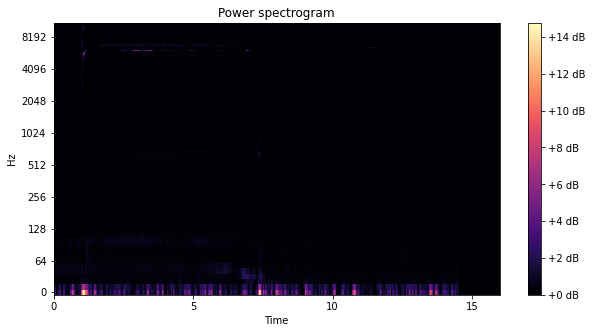

In [38]:
# librosa.stft
# https://librosa.org/doc/latest/generated/librosa.stft.html
# Time domain의 파형을 Frequency domain으로 변형시키는 푸리에 변환입니다.
# https://en.wikipedia.org/wiki/File:Fourier_transform_time_and_frequency_domains_(small).gif
# 푸리에 변환(Fourier transform, FT)은 시간이나 공간에 대한 함수를 시간 또는 공간 주파수 성분으로 분해하는 변환을 말한다.

y, sr = librosa.load('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')
spectrogram = np.abs(librosa.stft(y))

fig, ax = plt.subplots(figsize=(10,5))
# img = librosa.display.specshow(librosa.amplitude_to_db(S,
#                                                        ref=np.max),
#                                y_axis='log', x_axis='time', ax=ax)

# https://librosa.org/doc/0.9.1/generated/librosa.display.specshow.html
# https://librosa.org/doc/0.9.1/auto_examples/plot_display.html#sphx-glr-auto-examples-plot-display-py
img = librosa.display.specshow(spectrogram, sr=sr, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# STFT를 적용하여 구한 spectogram을 아래와 같이 시각화 해봤습니다.
#  x축은 시간, y축은 주파수, 그리고 짧은 시간의 주파수의 정도(진폭: Amplitude)를 색깔로 확인할 수 있습니다.
#  그런데 값이 너무 미세해서 차이를 파악하고 관찰하기 적합하지 않습니다.
#

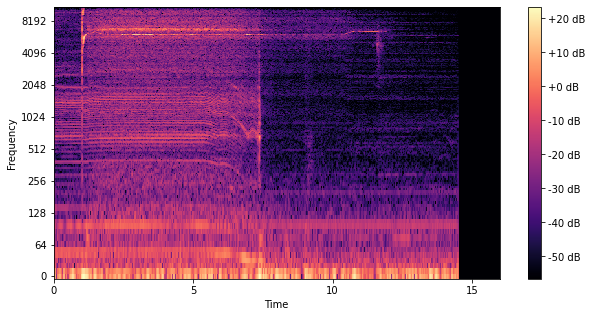

In [39]:
# https://lucaseo.github.io/posts/2021-01-22-hands-on-preprocess-audio-data/
# Log-spectogram
# 그래서 보통 푸리에변환 이후 dB(데시벨) scaling을 적용한 Log-spectogram을 구합니다.
#  다분히 시각적인 이유뿐만 아니라, 사람의 청각 또한 소리를 dB scale 로 인식하기 때문에,
#  이를 반영하여 spectogram을 나타내는 것이 분석에 용이합니다.

# librosa.amplitude_to_db()를 통해 Log-spectogram을 구하여 시각화 한 결과입니다.
#  대부분의 에너지가 1024Hz이하의 낮은 주파수대역에 모여 있는 것을 볼 수 있네요.
log_spectrogram = librosa.amplitude_to_db(spectrogram)

fig = plt.figure(figsize = (10,5))
librosa.display.specshow(log_spectrogram, 
                         sr=sr, 
                         hop_length=hop_length,
                         x_axis='time',
                         y_axis='log')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()

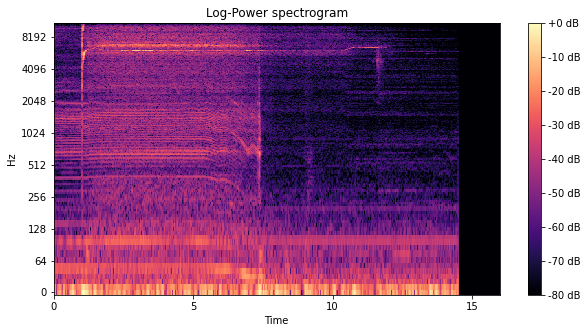

In [40]:
# https://librosa.org/doc/latest/generated/librosa.power_to_db.html
# librosa.power_to_db
# 파워 스펙트로그램(진폭 제곱)을 데시벨(dB) 단위로 변환

y, sr = librosa.load('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav')
S = np.abs(librosa.stft(y))

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(10,5))

imgdb = librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max),
                                 sr=sr, y_axis='log', x_axis='time', ax=ax)
ax.set(title='Log-Power spectrogram')
fig.colorbar(imgdb, ax=ax, format="%+2.0f dB")
ax.label_outer()

In [41]:
# https://lucaseo.github.io/posts/2021-01-22-hands-on-preprocess-audio-data/
# 4. MFCC
# 마지막으로 MFCC(Mel Frequency Cepstral Coefficient)를 구하고 시각화해보겠습니다.
#  MFCC는 오디오 신호 처리 분야에서 많이 사용되는 소리 데이터의 특징값(Feature)으로,
#  사람의 청각이 예민하게 반응하는 정보를 강조하여 소리가 가지는 고유한 특징을 추출한 값입니다.

# 마찬가지로 librosa.feature.mfcc()를 통해 feature값을 아래와 같이 추출할 수 있습니다.
#  파라미터 중 n_mfcc는 추출하고자 하는 mfcc의 개수입니다. 이번 실습에서는 13개로 설정했습니다.

In [42]:
# default sr=22050
MFCCs = librosa.feature.mfcc(y, 
                             sr = 22050,
                             n_fft = n_fft,
                             hop_length = hop_length,
                             n_mfcc = 13)   # number of coefficient we want to extract
print("MFCCs Shape: ", MFCCs.shape)
print("MFCCs: \n", MFCCs)

MFCCs Shape:  (13, 690)
MFCCs: 
 [[-482.25488   -457.3157    -459.72342   ... -853.98706   -853.98706
  -853.98706  ]
 [  65.6055      62.920868    57.899326  ...    0.           0.
     0.       ]
 [  -2.3342052   -8.673756   -13.152785  ...    0.           0.
     0.       ]
 ...
 [  25.587912    27.811867    29.436535  ...    0.           0.
     0.       ]
 [  16.2763      19.222612    20.666256  ...    0.           0.
     0.       ]
 [  -2.0718012   -3.7121942   -2.9246182 ...    0.           0.
     0.       ]]


C:\Users\astro\AppData\Local\Temp\ipykernel_16032\2457207560.py:2: FutureWarning: Pass y=[-0.00397271 -0.00660765 -0.0046689  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs = librosa.feature.mfcc(y,


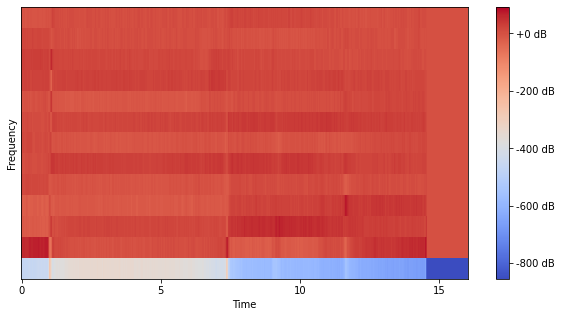

In [43]:
fig = plt.figure(figsize = (10,5))
librosa.display.specshow(MFCCs, 
                         sr=sr, 
                         hop_length=hop_length,
                         x_axis='time',)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()

36cc-normal


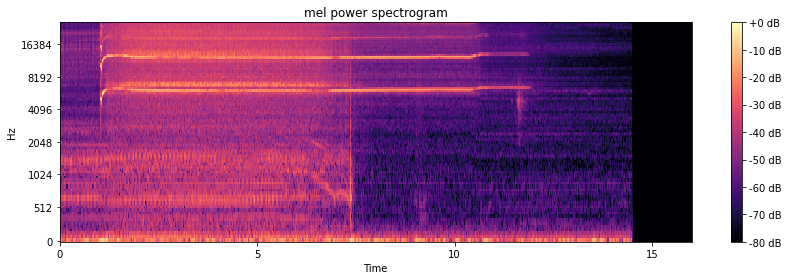

36cc-abnormal


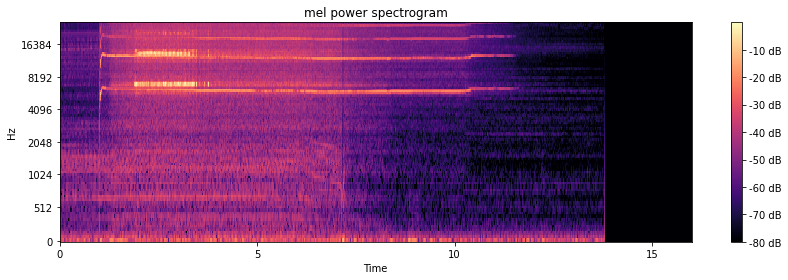

In [44]:
# 원본 36cc-normal 소리와 원본 36cc-abnormal 소리를 1개씩 spectrogra으로 변환하여 비교
print("36cc-normal")
make_iamge('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav', '')
print("36cc-abnormal")
make_iamge('./dataset/57cc/abnormal/57cc_NO_121281111NB982000266318.wav', '')

57cc-normal


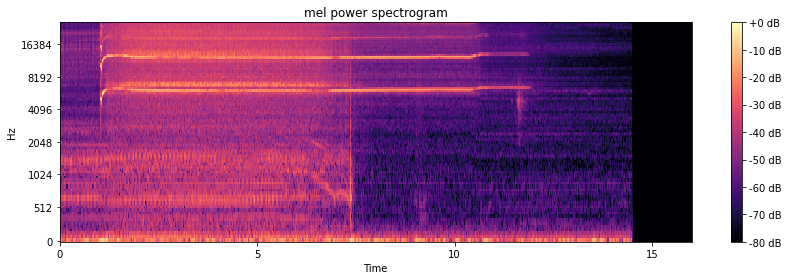

57cc-abnormal


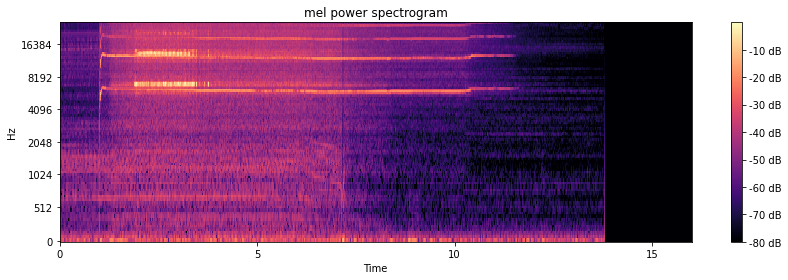

In [45]:
# 원본 57cc-normal 소리와 원본 57cc-abnormal 소리를 1개씩 spectrogra으로 변환하여 비교
print("57cc-normal")
make_iamge('./dataset/57cc/normal/57cc_OK_121281111NB982000266918.wav', '')
print("57cc-abnormal")
make_iamge('./dataset/57cc/abnormal/57cc_NO_121281111NB982000266318.wav', '')

In [46]:
# wav파일별로 Spectrogram 변환 실행위한 경로 변수 설정
# in_path = './content/data/wav_split_final/'
# out_path = './content/data/out/'
in_path = './dataset/57cc/'
out_path = './dataset/57cc_out/'
FIG_SIZE = (20, 20)
# label_path = ['abnormal','normal']
label_path = next(os.walk(in_path))[1]
len(label_path)

3

In [47]:
import os
# walk = os.walk("./content/data/wav_split_final/")
walk = os.walk("./dataset/57cc/")
print(walk)

<generator object _walk at 0x000001E78ED89BA0>


In [48]:
# Spectrogram image 변환 결과물 저장 위해 폴더 및 파일 삭제
import shutil
# shutil.rmtree(r'./content/data/out')
try:
    if os.path.exists('./dataset/57cc_out'):
        print("exist")
        shutil.rmtree(r'./dataset/57cc_out')
        print("deleted")
except OSError:
    print ('Error: Creating directory. ' +  './dataset/57cc_out')

exist
deleted


In [49]:
import os
# Spectrogram image 변환 결과물 저장폴더생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
# outfolder = './content/data/out'
outfolder = './dataset/57cc_out'
createFolder(outfolder)
for i in label_path:
  createFolder(outfolder+'/'+i)

In [50]:
# from tqdm import tqdm
# # wav파일별로 Spectrogram 변환 실행
# count = 0
# print("wav folders:", label_path)
# for i in label_path:
#         file_list = os.listdir(in_path+i)
#         count = count + 1
#         print(count,"/",len(label_path),' \'',i,'\'')
#         for j in tqdm(file_list, position=0, leave=True):
#             SOURCE = in_path+i+"/"+j
#             TARGET = out_path+i+"/"+j[:-3]+"jpg"
#             make_iamge(SOURCE, TARGET)

In [51]:
from tqdm import tqdm
# wav파일별로 Spectrogram 변환 실행
count = 0
print("wav folders:", label_path)
for i in label_path:
        file_list = os.listdir(in_path+i)
        count = count + 1
        print(count,"/",len(label_path),' \'',i,'\'')
        for j in tqdm(file_list, position=0, leave=True):
            SOURCE = in_path+i+"/"+j
            TARGET = out_path+i+"/"+j[:-3]+"jpg"
            make_iamge2(SOURCE, TARGET, FIG_SIZE)

wav folders: ['abnormal', 'normal', 'unknown']
1 / 3  ' abnormal '


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


2 / 3  ' normal '


100%|██████████| 24/24 [00:31<00:00,  1.32s/it]


3 / 3  ' unknown '


100%|██████████| 14/14 [00:18<00:00,  1.36s/it]


In [52]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [53]:
print(tf.__version__)

2.8.0


In [54]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/57cc_out')
print(type(data_dir))
print(data_dir)

<class 'pathlib.WindowsPath'>
dataset\57cc_out


In [55]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

45


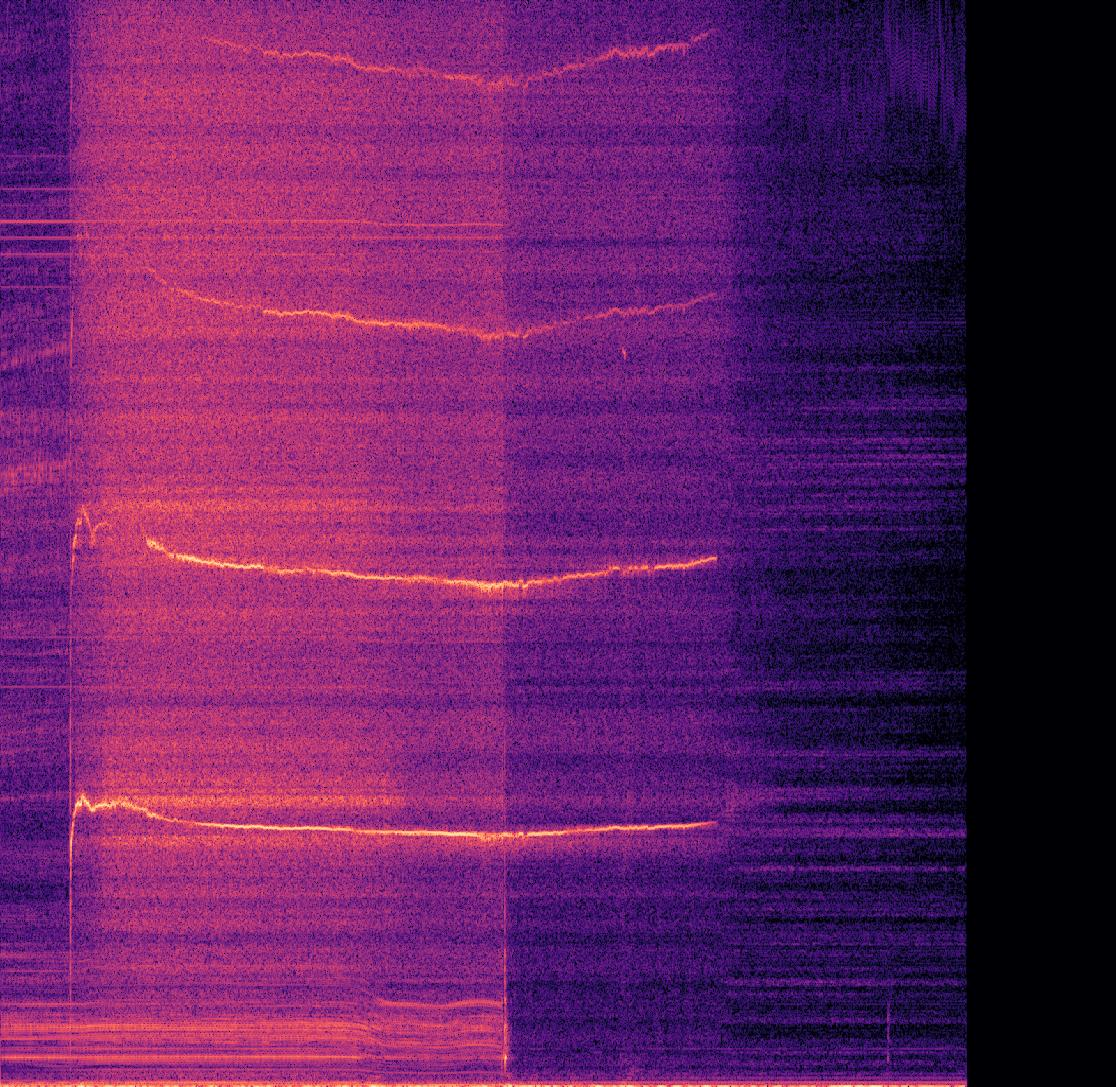

In [56]:
# image 1개 보기
# a_h = list(data_dir.glob('a_h/*'))
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[11]))

In [57]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [58]:

'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data



In [59]:

'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [60]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    threshold = np.mean(loss) + np.std(loss)
    return threshold


In [61]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss


In [202]:
'''
2. Load training images
'''
data_path = "./dataset/57cc_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/57cc_out/test"
x_test = create_training_data(data_path)

In [203]:
'''
3. Build autoencoder 
'''
autoencoder = Autoencoder(latent_dim=64 * 4)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(x_train, x_train,
						  epochs=20,
						  shuffle=True,
						  validation_data=(x_test, x_test))

Epoch 1/20
2/2 [==============================] - 0s 97ms/step - loss: 0.1065 - val_loss: 0.0710
Epoch 2/20
2/2 [==============================] - 0s 29ms/step - loss: 0.0779 - val_loss: 0.0207
Epoch 3/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0183 - val_loss: 0.0194
Epoch 4/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0166 - val_loss: 0.0148
Epoch 5/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
2/2 [==============================] - 0s 34ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 7/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0086 - val_loss: 0.0062
Epoch 8/20
2/2 [==============================] - 0s 28ms/step - loss: 0.0071 - val_loss: 0.0051
Epoch 9/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 10/20
2/2 [==============================] - 0s 32ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 11/20
2/2 [============

In [204]:
# a summary of architecture
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               12845312  
                                                                 
Total params: 12,845,312
Trainable params: 12,845,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 50176)             12895232  
                                                                 
 reshape_4 (Reshape)         (None, 224, 224)          0         
                                                                 
Total params: 12,895

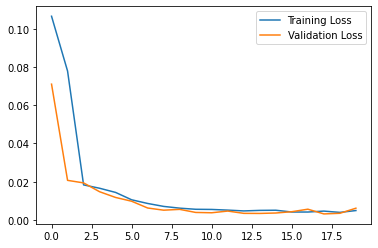

In [205]:
# plot history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [206]:
# save and load a mode
autoencoder.save('./model/')
autoencoder = keras.models.load_model('./model/')

INFO:tensorflow:Assets written to: ./model/assets


In [207]:
# load autoencoder model
if autoencoder is None:
	print("autoencoder is None")
	autoencoder = Autoencoder(latent_dim=64 * 2)
	autoencoder = keras.models.load_model('./model/')

In [208]:
'''
4. Set threshold
'''
threshold = model_threshold(autoencoder, x_train)
# loss = tf.keras.losses.mse(decoded_imgs, x_train)
# threshold = np.mean(loss) + np.std(loss)
print("Loss Threshold: ", threshold)

Loss Threshold:  0.008786120090754253


In [209]:
# load autoencoder model
if autoencoder is None:
	print("autoencoder is None")
	autoencoder = keras.models.load_model('./model/')

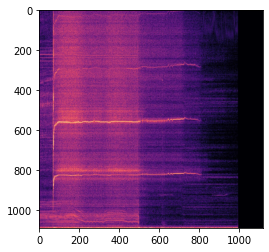

In [214]:
'''
5. Make an inference
'''
# get statistics for each spectrogram
file = './dataset/57cc_out/test/57cc_OK_121281111NB982000267818.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [215]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

Loss is smaller than threshold 
 		  Sample Loss: 0.008098997175693512 
 		  Threshold: 0.008786120090754253 
